In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms  import ToTensor

import matplotlib.pyplot as plt

print(f"torch: {torch.__version__}")
print(f"torcvision: {torchvision.__version__}")

torch: 1.12.1+cu113
torcvision: 0.13.1+cu113


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

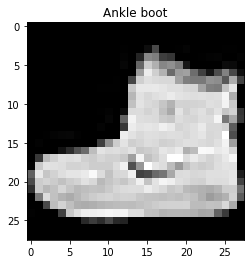

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

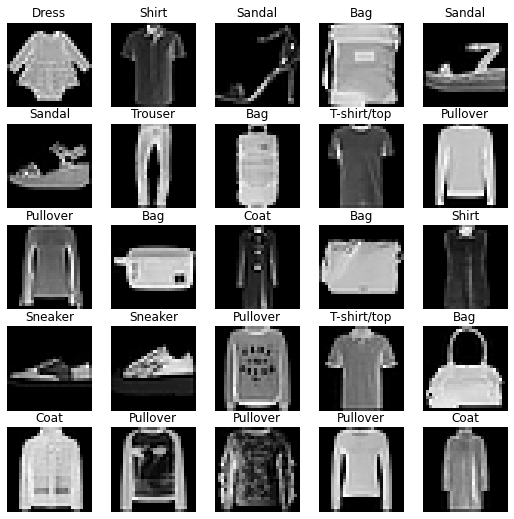

In [ ]:
fig = plt.figure(figsize=(9,9))
rows, cols= 5, 5
for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
from  torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

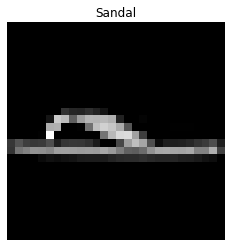

In [ ]:
rand_idx = torch.randint(0, 32, size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [ ]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
class ModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

model0 = ModelV0(784, 10, len(class_names)).to(device)
model0

ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
def accuracy(y_true, y_pred):
    return ((torch.eq(y_true, y_pred).sum().item())/len(y_pred)) * 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    t = end-start
    print(f"Train time on {device}: {t:.3f} seconds")
    return t

In [ ]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    return train_loss

def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss+=loss
            acc = acc_fn(y, y_pred.argmax(dim=1))
            test_acc+=acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_loss = train_step(model0, train_dataloader, loss_fn, optimizer, device)
    
    test_loss, acc = test_step(model0, test_dataloader, loss_fn, accuracy, device)

    print(f"Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f} Acc: {acc:.5f}")        

end = timer()
model0_time = print_train_time(start, end, device=str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.02341 Test Loss: 0.78296 Acc: 72.74361
Epoch: 1
Train Loss: 0.68316 Test Loss: 0.71166 Acc: 73.86182
Epoch: 2
Train Loss: 0.65284 Test Loss: 0.67759 Acc: 75.37939
Train time on cuda:0: 24.947 seconds


In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model": model.__class__.__name__, "loss":loss.item(), "acc":acc}

model0_results = eval_model(model0, test_dataloader, loss_fn, accuracy)
model0_results

{'model': 'ModelV0', 'loss': 0.6775925755500793, 'acc': 75.379392971246}

In [ ]:
class ModelV1(nn.Module):

    def __init__(self, input: int, hidden: int, output: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden*7*7, output)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

model1 = ModelV1(1, 10, len(class_names)).to(device)
model1

ModelV1(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
images.shape, test_image.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [ ]:
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10, 
                       kernel_size=5, 
                       stride=2,
                       padding=0)

test_image_through_conv = conv_layer(test_image)
test_image_through_conv.shape

torch.Size([10, 30, 30])

In [ ]:
print(conv_layer.weight.shape)
print(conv_layer.bias.shape)

torch.Size([10, 3, 5, 5])
torch.Size([10])


In [ ]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
test_image_through_conv_and_max_pool.shape

torch.Size([10, 15, 15])

In [ ]:
random_tensor = torch.randn(1,2,2)
print(random_tensor)

tensor([[[ 0.0741,  0.1586],
         [ 0.4837, -0.1286]]])


In [ ]:
print(random_tensor.max())
max_pool_layer(random_tensor)

tensor(0.4837)


tensor([[[0.4837]]])

In [ ]:
print(random_tensor.mean())
avg_pool_layer = nn.AvgPool2d(2)
avg_pool_layer(random_tensor)

tensor(0.1470)


tensor([[[0.1470]]])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [ ]:
from tqdm.auto import tqdm

start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_loss = train_step(model1, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model1, test_dataloader, loss_fn, accuracy, device)
    print(f"Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f} Accuracy: {test_acc:.5f}")

end = timer()

model1_time = print_train_time(start, end, str(next(model1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train Loss: 0.69875 Test Loss: 0.44053 Accuracy: 83.64617
Epoch 1
Train Loss: 0.36755 Test Loss: 0.36742 Accuracy: 86.83107
Epoch 2
Train Loss: 0.33239 Test Loss: 0.33702 Accuracy: 87.82947
Train time on cuda:0: 35.484 seconds


In [ ]:
model1_results = eval_model(model1, test_dataloader, loss_fn, accuracy)
model1_results

{'model': 'ModelV1', 'loss': 0.3370248079299927, 'acc': 87.82947284345047}

In [ ]:
import pandas as pd

compare_results = pd.DataFrame([model0_results, model1_results])
compare_results

,model,loss,acc
0,ModelV0,0.677593,75.379393
1,ModelV1,0.337025,87.829473


In [ ]:
compare_results["training time"] = [model0_time, model1_time]
compare_results

,model,loss,acc,training time
0,ModelV0,0.677593,75.379393,24.947315
1,ModelV1,0.337025,87.829473,35.483659


Text(0, 0.5, 'model')

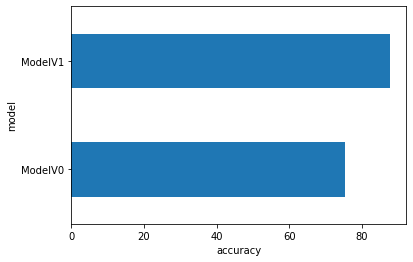

In [ ]:
compare_results.set_index("model")["acc"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model")

In [ ]:
def make_preds(model: nn.Module,
               data: list,
               device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)   
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [ ]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape, test_labels[0], class_names[test_labels[0]]

(torch.Size([1, 28, 28]), 6, 'Shirt')

In [ ]:
pred_probs = make_preds(model1, test_samples)

pred_probs.shape

torch.Size([9, 10])

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([6, 0, 3, 7, 1, 5, 6, 5, 8]), [6, 0, 3, 7, 1, 5, 6, 5, 8])

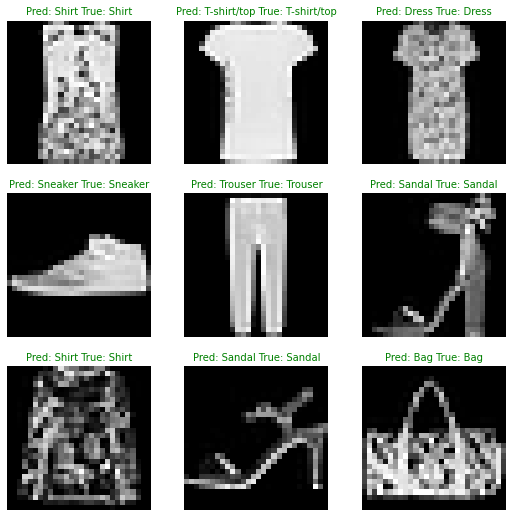

In [ ]:
plt.figure(figsize=(9,9))

rows = 3
cols =  3

for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i+1)

    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = class_names[pred_classes[i]]

    true_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} True: {true_label}"

    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c='g')
    else: 
        plt.title(title_text, fontsize=10, c='g')
    plt.axis(False)

In [ ]:
y_preds = []
model1.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions: "):
        X, y = X.to(device), y.to(device)
        y_logit = model1(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
!pip install -q torchmetrics -U mlxtend

     |████████████████████████████████| 419 kB 7.1 MB/s 
     |████████████████████████████████| 1.3 MB 49.7 MB/s 


In [ ]:
import mlxtend
assert int(mlxtend.__version__.split('.')[1]) >= 19

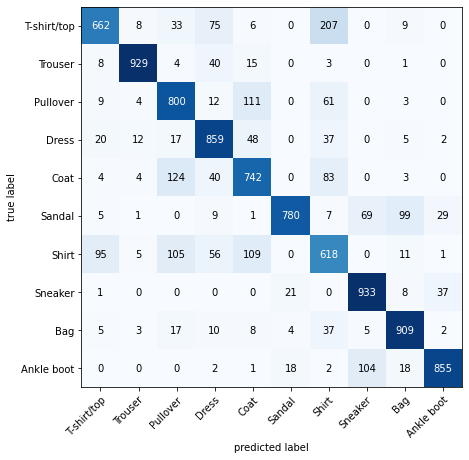

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds = pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [ ]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / "model1.pth"
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(), f=MODEL_SAVE_PATH)
print("Done!")

Saving model to models/model1.pth
Done!


In [ ]:
loaded_model1 = ModelV1(1, 10, 10).to(device)

loaded_model1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model1_results = eval_model(
    model=loaded_model1,
    data_loader=test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn=accuracy
)

loaded_model1_results

{'model': 'ModelV1', 'loss': 0.3370248079299927, 'acc': 87.82947284345047}

In [ ]:
model1_results

{'model': 'ModelV1', 'loss': 0.3370248079299927, 'acc': 87.82947284345047}

In [ ]:
torch.isclose(
    torch.tensor(model1_results["loss"]),
    torch.tensor(loaded_model1_results["loss"]),
    atol=1e-08,
    rtol=0.0001
)

tensor(True)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    )

test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    )
train_data, test_data

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

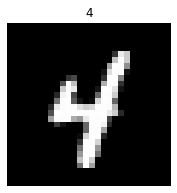

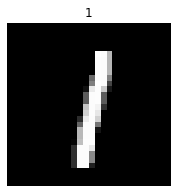

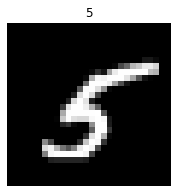

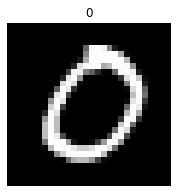

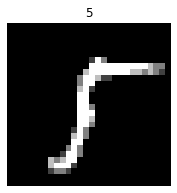

In [4]:
for i in range(5):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    plt.figure(figsize=(3,3))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label)
    plt.axis(False)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [6]:
class TinyVGG(nn.Module):
    def __init__(self, input, output, hidden):
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(input,hidden,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden,hidden,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.block2=nn.Sequential(
            nn.Conv2d(hidden,hidden,3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden,hidden,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden*7*7, output)
        )
    def forward(self, x):
        self.classifier(self.block2(self.block1(x)))

model = TinyVGG(1, 10, 10).to(device)
model

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)